In [290]:

import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt


In [291]:

df = pd.DataFrame(columns=['ilosc_przejazdow', 'data_przejazdu'])

html_page = requests.get("https://www.wroclaw.pl/open-data/dataset/wrmprzejazdy_data/resource_history/c737af89-bcf7-4f7d-8bbc-4a0946d7006e").text
soup = BeautifulSoup(html_page, 'html.parser')
list = soup.find_all(class_='heading')
list = list[1:]
list.reverse()

In [292]:
date2022 = datetime.datetime(2022, 1, 1)

In [293]:

for elem in list:

    name = elem.contents
    elem = str(elem)

    name = str(name)
    name = name.split("_")[2]

    date = datetime.datetime(int(name.split("-")[0]), int(name.split("-")[1]), int(name.split("-")[2]))
    if date>=date2022:
        link = elem.split(" ")
        link = link[2]
        link = link[5:]
        link = link[1:]
        link = link[:-1]

        if os.path.exists(os.path.join("daily_csv", f"{name}.csv")):
            dailyDate = pd.read_csv(os.path.join("daily_csv", f"{name}.csv"))
            quantity = len(dailyDate)
            df = df.append({'ilosc_przejazdow':quantity,'data_przejazdu':name},ignore_index=True)
            continue

        dailyDate = pd.read_csv(link)
        dailyDate.to_csv(os.path.join("daily_csv", f"{name}.csv"))
        quantity = len(dailyDate)
        df = df.append({'ilosc_przejazdow':quantity,'data_przejazdu':name},ignore_index=True)



In [294]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["data_przejazdu"],
                         y=df["ilosc_przejazdow"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.show()

In [295]:

all_files = glob.glob("root_csv"+"/*.csv")
archieved = pd.concat(map(pd.read_csv, all_files), ignore_index=True)
archieved = pd.DataFrame(archieved, columns=["UID wynajmu","Data zwrotu"])
archieved["Data zwrotu"] = pd.to_datetime(archieved["Data zwrotu"]).dt.date
archieved= archieved.groupby(archieved["Data zwrotu"]).count()
archieved = archieved.reset_index()

In [296]:
archieved["ilosc_przejazdow"] = archieved["UID wynajmu"]
archieved["data_przejazdu"] = archieved["Data zwrotu"]
archieved


,Data zwrotu,UID wynajmu,ilosc_przejazdow,data_przejazdu
0,2020-01-01,634,634,2020-01-01
1,2020-01-02,971,971,2020-01-02
2,2020-01-03,1017,1017,2020-01-03
3,2020-01-04,492,492,2020-01-04
4,2020-01-05,629,629,2020-01-05
...,...,...,...,...
665,2021-11-26,3663,3663,2021-11-26
666,2021-11-27,3158,3158,2021-11-27
667,2021-11-28,1191,1191,2021-11-28
668,2021-11-29,2707,2707,2021-11-29


In [297]:
all_time = pd.concat([archieved, df], ignore_index=True).drop(["Data zwrotu", "UID wynajmu"], axis=1)
all_time["data_przejazdu"] = pd.to_datetime(all_time["data_przejazdu"], format='%Y-%m-%d').dt.date
all_time.set_index("data_przejazdu", inplace=True)
all_time

,ilosc_przejazdow
data_przejazdu,
2020-01-01,634
2020-01-02,971
2020-01-03,1017
2020-01-04,492
2020-01-05,629
...,...
2022-06-10,12488
2022-06-11,10412
2022-06-12,12299


In [298]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=all_time.index,
                         y=all_time["ilosc_przejazdow"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.show()

In [299]:
import meteostat
# from datetime import datetime, timedelta
# Przygotowanie obiektów dat
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.now()

# Pobieranie danych nt. stacji
stations = meteostat.Stations()
wroclaw_req = stations.nearby(51, 17)
wroclaw = wroclaw_req.fetch(1)

# Pobieranie danych ze stacji day by day
weather_data_req = meteostat.Daily(wroclaw, start, end)
weather_data = weather_data_req.fetch()
weather_data = weather_data.reset_index()
weather_data = weather_data[["time", "tavg", "prcp"]]
weather_data["time"] = pd.to_datetime(weather_data["time"]).dt.date
weather_data.set_index("time", inplace=True)
weather_data


,tavg,prcp
time,,
2020-01-01,1.3,0.0
2020-01-02,-2.2,0.0
2020-01-03,1.1,0.0
2020-01-04,4.3,0.5
2020-01-05,0.3,1.0
...,...,...
2022-06-10,20.1,0.0
2022-06-11,19.2,0.0
2022-06-12,22.1,0.0


In [300]:

merged = all_time.join(weather_data)
merged = merged.dropna()
merged


,ilosc_przejazdow,tavg,prcp
2020-01-01,634,1.3,0.0
2020-01-02,971,-2.2,0.0
2020-01-03,1017,1.1,0.0
2020-01-04,492,4.3,0.5
2020-01-05,629,0.3,1.0
...,...,...,...
2022-06-10,12488,20.1,0.0
2022-06-11,10412,19.2,0.0
2022-06-12,12299,22.1,0.0
2022-06-13,12336,17.8,3.8


In [301]:
merged["rolling_avg_7d"] = merged["ilosc_przejazdow"].rolling(7).mean()
merged = merged.dropna()
merged = merged.astype({'rolling_avg_7d':'int'})

merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d
2020-01-07,1252,1.5,0.0,795
2020-01-08,1312,4.6,0.0,891
2020-01-09,1410,6.9,2.5,954
2020-01-10,1788,8.2,1.0,1064
2020-01-11,998,4.3,0.0,1137
...,...,...,...,...
2022-06-10,12488,20.1,0.0,10459
2022-06-11,10412,19.2,0.0,10332
2022-06-12,12299,22.1,0.0,10407
2022-06-13,12336,17.8,3.8,10991


In [305]:
merged['prev_value'] = merged["ilosc_przejazdow"].shift(1)
merged = merged.dropna()
merged = merged.astype({'prev_value':'int'})
merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d,prev_value,months
2020-01-09,1410,6.9,2.5,954,1312,1
2020-01-10,1788,8.2,1.0,1064,1410,1
2020-01-11,998,4.3,0.0,1137,1788,1
2020-01-12,1114,2.8,0.0,1206,998,1
2020-01-13,1659,3.7,0.0,1361,1114,1
...,...,...,...,...,...,...
2022-06-10,12488,20.1,0.0,10459,6806,6
2022-06-11,10412,19.2,0.0,10332,12488,6
2022-06-12,12299,22.1,0.0,10407,10412,6
2022-06-13,12336,17.8,3.8,10991,12299,6


In [307]:
merged['months'] = pd.DatetimeIndex(merged.index).month
df = pd.DataFrame({'months': ['1', '2', '3','4','5','6','7','8','9','10','11','12']})

pd.get_dummies(df["months"],prefix='months',drop_first=True)

,months_10,months_11,months_12,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,1
9,1,0,0,0,0,0,0,0,0,0,0


In [308]:
merged = pd.concat([merged,pd.get_dummies(merged['months'], prefix='months')],axis=1)
merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d,prev_value,months,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2020-01-09,1410,6.9,2.5,954,1312,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-10,1788,8.2,1.0,1064,1410,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-11,998,4.3,0.0,1137,1788,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-12,1114,2.8,0.0,1206,998,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-13,1659,3.7,0.0,1361,1114,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-10,12488,20.1,0.0,10459,6806,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-11,10412,19.2,0.0,10332,12488,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-12,12299,22.1,0.0,10407,10412,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-13,12336,17.8,3.8,10991,12299,6,0,0,0,0,0,1,0,0,0,0,0,0


In [309]:
X = merged.drop(["ilosc_przejazdow"], axis=1)
X = X.drop(["months"], axis=1)
X = X.drop(["rolling_avg_7d"], axis=1)
from_ts = pd.to_datetime('2020-03-25')
to_ts = pd.to_datetime('2020-04-10')
X = X[(X.index < from_ts) | (X.index > to_ts)]
idx = np.unique(X.index.values, return_index=True)[1]
X = X.iloc[idx]
Y = merged["rolling_avg_7d"].iloc[idx]

In [310]:
X

,tavg,prcp,prev_value,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2020-01-09,6.9,2.5,1312,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-10,8.2,1.0,1410,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-11,4.3,0.0,1788,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-12,2.8,0.0,998,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-13,3.7,0.0,1114,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-10,20.1,0.0,6806,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-11,19.2,0.0,12488,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-12,22.1,0.0,10412,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-13,17.8,3.8,12299,0,0,0,0,0,1,0,0,0,0,0,0


In [311]:
X[X.reset_index()["index"].duplicated().values]

,tavg,prcp,prev_value,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12


In [312]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [313]:

X_train

,tavg,prcp,prev_value,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2021-10-19,11.4,0.0,5996,0,0,0,0,0,0,0,0,0,1,0,0
2021-10-22,9.1,0.0,9271,0,0,0,0,0,0,0,0,0,1,0,0
2020-09-19,12.4,0.0,7539,0,0,0,0,0,0,0,0,1,0,0,0
2021-01-26,0.2,0.8,1197,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-01,12.7,0.8,6191,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-24,0.7,0.0,1655,0,0,1,0,0,0,0,0,0,0,0,0
2020-06-09,16.3,0.0,4136,0,0,0,0,0,1,0,0,0,0,0,0
2020-11-24,3.4,0.0,2551,0,0,0,0,0,0,0,0,0,0,1,0
2021-10-20,16.9,0.0,8183,0,0,0,0,0,0,0,0,0,1,0,0


In [314]:
from scipy.optimize import curve_fit

def func(x, a, b, d, e, f, g, h, i, j, k, l, m, n, o, p, q):
    return a*x["tavg"] + b*x["prcp"] + d*x["prev_value"] + e*x["months_1"] + f*x["months_2"] + g*x["months_3"] + h*x["months_4"] + i*x["months_5"] + j*x["months_6"] + k*x["months_7"] + l*x["months_8"]+ m*x["months_9"] + n*x["months_10"] + o*x["months_11"] + p*x["months_12"] + q
params, _ = curve_fit(func, xdata=X_train, ydata=Y_train)
params

array([-3.77667964e+00,  2.93886870e+01,  3.16716632e-01, -4.00270304e+05,
       -4.00540598e+05, -4.00318463e+05, -4.00878533e+05, -4.00299910e+05,
       -3.98363331e+05, -3.97590397e+05, -3.95344638e+05, -3.96166862e+05,
       -3.97021800e+05, -3.98111434e+05, -4.00073381e+05,  4.01684347e+05])

<AxesSubplot:>

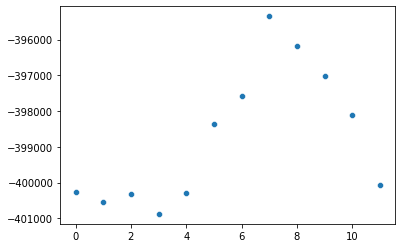

In [315]:
months = params[3:-1]
sns.scatterplot(data=months)

In [316]:
class CustomModelWrapper:
    def __init__(self, pred_fun, params):
        self.pred_fun = pred_fun
        self.params = params

    def predict(self, x):
        return self.pred_fun(x, *params)

In [317]:
model_custom = CustomModelWrapper(func, params)

In [318]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

model_svr = SVR()
model_svr.fit(X_train, Y_train)
Y_pred = model_svr.predict(X_test)

svr_mse = mean_squared_error(Y_test, Y_pred)
svr_mse

9118328.2156802

In [319]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(X_train, Y_train)
Y_pred = model_lin.predict(X_test)

lin_mse = mean_squared_error(Y_test, Y_pred)
lin_mse

2302791.8820330626

In [320]:
Y_pred = model_custom.predict(X_test)

custom_mse = mean_squared_error(Y_test, Y_pred)
custom_mse

2302791.773872104

In [321]:
pd.DataFrame({"pred": Y_pred, "true": Y_test}).join(X_test)

,pred,true,tavg,prcp,prev_value,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2020-01-09,1876.988170,954.0,6.9,2.5,1312.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-11,1964.092936,1137.0,4.3,0.0,1788.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,1959.257315,1503.0,3.4,0.0,1762.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19,1898.168037,1554.0,2.3,0.0,1556.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-20,1734.474529,1646.0,1.7,0.0,1032.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,6841.179214,NaN,17.9,0.0,11328.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08,6961.521970,NaN,19.1,0.1,11713.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-10,5400.677907,NaN,20.1,0.0,6806.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-11,7203.660824,NaN,19.2,0.0,12488.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:ylabel='rolling_avg_7d'>

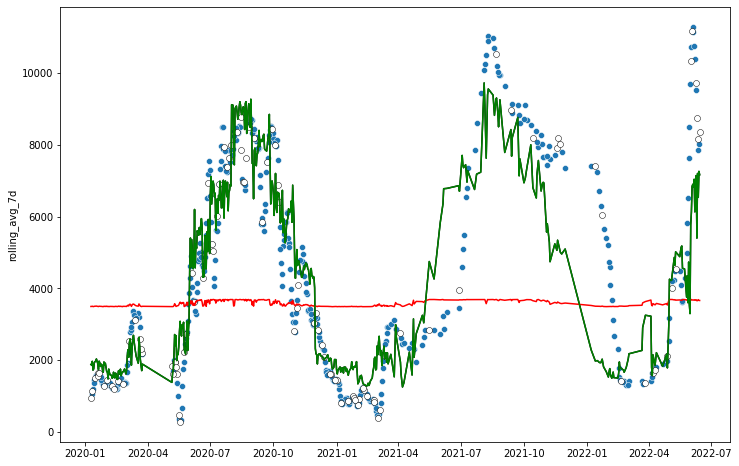

In [322]:


fig = plt.gcf()

fig.set_size_inches(12, 8)
sns.scatterplot(x=X_train.index, y=Y_train)
sns.scatterplot(x=X_test.index, y=Y_test, color="white", edgecolor="black")
sns.lineplot(x=X.index, y=model_custom.predict(X), color="black")
sns.lineplot(x=X.index, y=model_svr.predict(X), color="red")
sns.lineplot(x=X.index, y=model_lin.predict(X), color="green")

In [323]:
X_test

,tavg,prcp,prev_value,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2020-11-29,2.0,0.0,2368,0,0,0,0,0,0,0,0,0,0,1,0
2020-05-27,13.6,0.0,3809,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-15,3.4,0.0,1762,1,0,0,0,0,0,0,0,0,0,0,0
2020-08-09,25.3,0.0,8427,0,0,0,0,0,0,0,1,0,0,0,0
2020-05-24,12.5,20.6,1093,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,-0.7,0.0,1589,0,0,1,0,0,0,0,0,0,0,0,0
2021-02-25,10.1,0.0,2962,0,1,0,0,0,0,0,0,0,0,0,0
2021-09-12,18.0,0.0,9399,0,0,0,0,0,0,0,0,1,0,0,0
2021-01-28,0.3,0.0,1339,1,0,0,0,0,0,0,0,0,0,0,0
